In [2]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import swifter

# stats imports
import statsmodels.api as sm
import pingouin as pt
from scipy.stats import pearsonr

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error

# mapping imports
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster, MarkerCluster
from branca.element import Template, MacroElement # import to add legend method


In [3]:
pd.options.display.max_columns=300
sns.set_style('darkgrid')

## Mapping Features

#### Full Screen Plugin

In [4]:
def add_full_screen(map):
    ''' Add full screen option to map '''
    plugins.Fullscreen(
        position="topright",
        title="Expand me",
        title_cancel="Exit me",
        force_separate_button=True,
    ).add_to(map)
    
    return map

In [5]:
#### Add Title to Map

In [6]:
def add_map_title(title:str, map):
    htmlTitle = f'''<h3 align="center" style="font-size:16px"><b>{title}</b></h3>'''
    map.get_root().html.add_child(folium.Element(htmlTitle))
    
    return map

# Stats Model Function

In [7]:
def get_stats(df, cols):
    x = df[cols]
    y = df.averageWanLatency
    results = sm.OLS(y, x).fit()
    return results

#### Read Data

In [8]:
df = pd.read_csv('Raw/analytic.csv')

# Heat Map of Holy Cross Energy Service Area

In [9]:
def create_heat_map(df):
    heatData = [[row['latitude'], row['longitude']] for index, row in df.iterrows()]
    map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=9)

    HeatMap(heatData).add_to(map)

    # Add title to the map
    title = add_map_title('Holy Cross Energy Service Area', map)

    # add full screen widget
    map = add_full_screen(map)

    # show map
    return map

In [10]:
heatMap = create_heat_map(df)
heatMap

### Essential DF Info

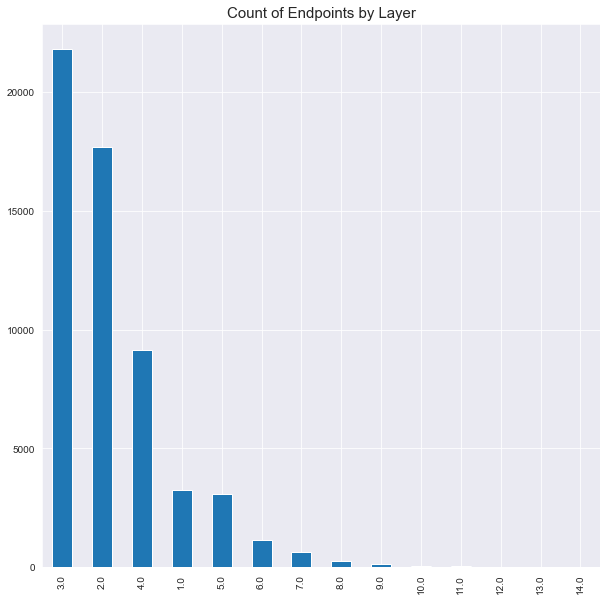

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
ax = df.layer.value_counts(sort=True, ascending=False).plot.bar()
ax.set_title('Count of Endpoints by Layer', fontsize=15)
ax.set_ylabel('');

In [12]:
df.averageWanLatency.describe()

count    57249.000000
mean       976.335220
std        821.374228
min        128.000000
25%        514.000000
50%        811.000000
75%       1222.000000
max      50001.000000
Name: averageWanLatency, dtype: float64

### Data Cleaning

In [13]:
# convert columns to date time
df['currentDate'] = pd.to_datetime(df.currentDate)
df['lastReboot'] = pd.to_datetime(df.lastReboot)
df['sent'] = pd.to_datetime(df['sent'])
df['completed'] = pd.to_datetime(df['completed'])

In [14]:
# Create Integers from largest hops/distanceToCollector
df['largestHop_int'] = round(df.largestHop, 0)
df['largestHop_int'] = df.largestHop_int.astype(int)
df['distanceToCollector_int'] = round(df.distanceToCollector, 0)
df['distanceToCollector_int'] = df.distanceToCollector_int.astype(int)
df['totalHopDistance_int'] = round(df.totalHopDistance, 0)
df['totalHopDistance_int'] = df.totalHopDistance_int.astype(int)

# Add Features

##### Add total number of meters in the same location

In [15]:
stackCountDF = df.groupby(['latitude', 'longitude']).count().sort_values('meterNo', ascending=False).copy()
stackCountDF = stackCountDF[['meterNo']] 
stackCountDF.rename(columns={'meterNo':'meterStackCount'}, inplace=True)
stackCountDF.reset_index(inplace=True)
df = pd.merge(df, stackCountDF, on=['latitude', 'longitude'])

### Add a color row based on collector name

In [16]:
def set_value(row_number, assigned_value):
    return assigned_value[row_number]

colorDict = {'HCE_SpraddleCrk': 'red',
             'HCE_EastVail': 'blue',
             'HCE_MidVail': 'green',
             'HCE_AvonSub': 'purple',
             'HCE_WestVail': 'orange',
             'HCE_BeaverCrkSub': 'darkred',
             'HCE_WolcottSub': 'lightred',
             'HCE_Edwards': 'darkblue', 
             'HCE_AspenSub': 'darkgreen', 
             'HCE_BasaltSub': 'darkpurple',
             'HCE_CooleyMesaSub': 'cadetblue',
             'HCE_CrystalSub': 'pink',
             'HCE_SnowmassSub': 'lightblue',
             'HCE_ParachuteSub': 'lightgreen',
             'HCE_Silt': 'olivedrab',
             'HCE_TaughenbaughMesa': 'magenta',
             'HCE_Rulison': 'indigo',
             'HCE_GlenwoodCampus': 'lime',
             'HCE_Battlement': 'coral',
             'HCE_Marble': 'peru'}


df['color'] = df['name'].apply(set_value, args =(colorDict, ))

## Feature Selection

* <u>pathCount</u> removed because it is nearly highly coorelated to layer
* <u>activeWanNeighbors</u> removed because it is a duplicate of numberOfNeighbors

In [17]:
# Numeric Columns
cols = ['lagTimeSeconds',
        'layer',
        'latestTickleSuccess',
        'numberOfNeighbors',
        'responseTimeToLive',
        'collectorDelay',
        'wanDataSuccess',
        'wanPacketsReceived',
        'wanPacketsTransmitted',
        'tickleSuccess',
        'transparentPacketsReceived',
        'transparentPacketsTransmitted',
        'largestHop',
        'distanceToCollector',
        'totalHopDistance',
        'rssi_dBm',
        'rfPower_dBm',
        'daysFromLastReboot',
        'averageWanLatency']

### Descriptive statistics for all Numeric Columns in data set

In [18]:
for col in cols:
    print(f'Column name: {col}')
    print(df[col].describe())
    print('-'* 60 + '\n')

Column name: lagTimeSeconds
count    57249.000000
mean       445.514797
std       1670.288706
min          3.117000
25%         22.847000
50%         43.717000
75%         90.570000
max      11459.143000
Name: lagTimeSeconds, dtype: float64
------------------------------------------------------------

Column name: layer
count    57249.000000
mean         3.005467
std          1.273832
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         14.000000
Name: layer, dtype: float64
------------------------------------------------------------

Column name: latestTickleSuccess
count    57249.000000
mean         0.644953
std          0.128737
min          0.070000
25%          0.560000
50%          0.640000
75%          0.730000
max          1.000000
Name: latestTickleSuccess, dtype: float64
------------------------------------------------------------

Column name: numberOfNeighbors
count    57249.000000
mean        52.158378
std         15.722343
mi

## Create final data frame

# DF layers - No Outliers Removed
* Outliers above 10,000 miliseconds seem to have a large influene on the dataset, however, they also seem to be layer dependent.

In [19]:
df.averageWanLatency.describe()

count    57249.000000
mean       976.335220
std        821.374228
min        128.000000
25%        514.000000
50%        811.000000
75%       1222.000000
max      50001.000000
Name: averageWanLatency, dtype: float64

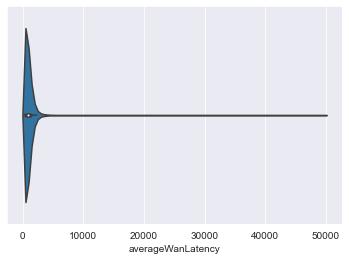

In [20]:
sns.violinplot(df.averageWanLatency);

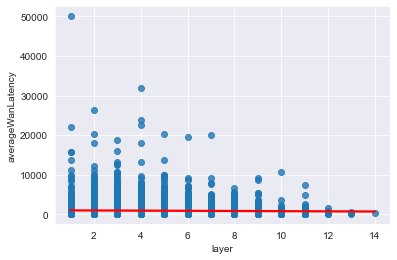

In [21]:
sns.regplot(x='layer', y='averageWanLatency', data=df, line_kws={'color':'red'});

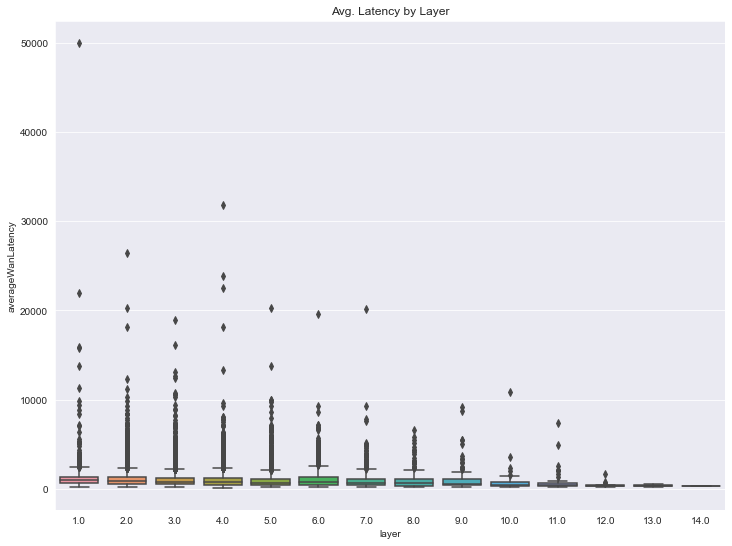

In [22]:
fig = plt.figure(figsize=(12,9))
plt.title('Avg. Latency by Layer')
sns.boxplot(y='averageWanLatency', x='layer', data=df);

### Remove outliers in each layer as opposed to the entire dataset

In [23]:
outlierDF = pd.DataFrame() # create blank df to store outliers for further exploration.

#### Loop through each layer and remove all devices about the upper quartile

In [24]:
layers = list(df.layer.unique())
layers.sort()
for layer in layers:
    upper = df.loc[df.layer == layer].averageWanLatency.quantile(.99)
    temp = df.loc[(df.layer == layer) & (df.averageWanLatency > upper)]
    outlierDF = pd.concat([outlierDF, temp])

In [25]:
analyticDF = df.drop(list(outlierDF.index))
analyticDF = analyticDF.loc[analyticDF.totalHopDistance < 100] # remove devices that hop through improperly located devices

###  Final DF for analysis - outliers removed
* No devices with average WAN Latency above 6000 ms
* Only removed 577 as oposed to 14,000 devices

In [26]:
analyticDF.averageWanLatency.describe()

count    56672.000000
mean       929.265581
std        570.415596
min        128.000000
25%        511.000000
50%        805.000000
75%       1206.000000
max       5752.000000
Name: averageWanLatency, dtype: float64

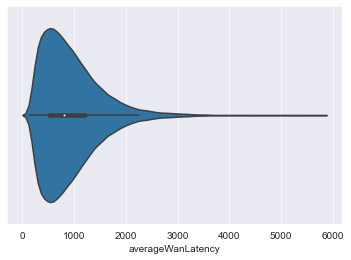

In [27]:
sns.violinplot(analyticDF.averageWanLatency);

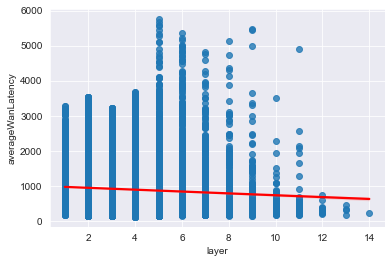

In [28]:
sns.regplot(x='layer', y='averageWanLatency', data=analyticDF, line_kws={'color':'red'});

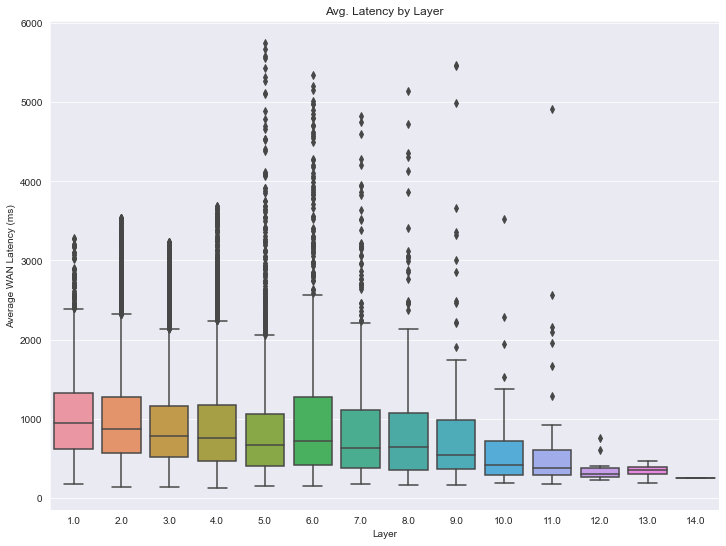

In [29]:
fig = plt.figure(figsize=(12,9))
plt.title('Avg. Latency by Layer')
ax = sns.boxplot(y='averageWanLatency', x='layer', data=analyticDF)
ax.set_ylabel('Average WAN Latency (ms)')
ax.set_xlabel('Layer');

# Outlier DF - Data description

In [30]:
outlierDF.averageWanLatency.describe()

count      577.000000
mean      5599.438475
std       3662.305380
min        563.000000
25%       3806.000000
50%       4513.000000
75%       5989.000000
max      50001.000000
Name: averageWanLatency, dtype: float64

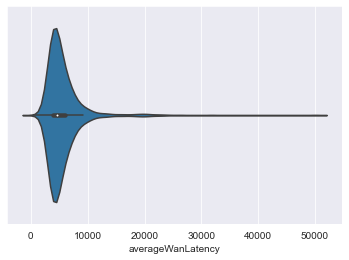

In [31]:
sns.violinplot(outlierDF.averageWanLatency);

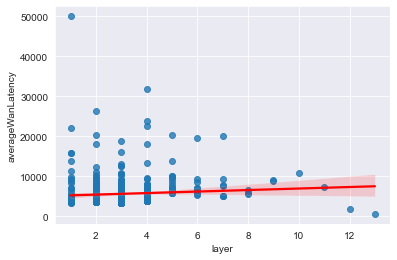

In [32]:
sns.regplot(x='layer', y='averageWanLatency', data=outlierDF, line_kws={'color':'red'});

In [33]:
outlierDF.to_csv('Raw/outliers.csv')

# Previous Outlier Removal
* Removes over 14,000 rows.
* Analysis not as robust

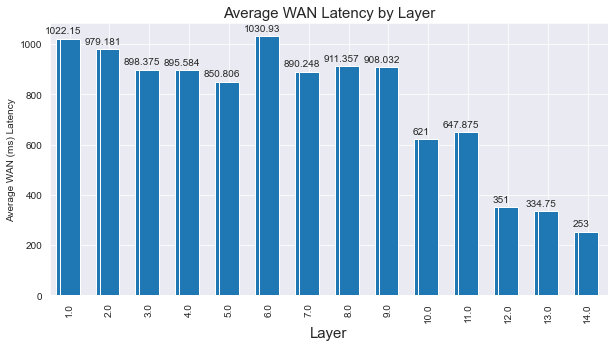

In [34]:
# Create Labels for Bar Chart
latencyLabel = list(analyticDF.groupby('layer').averageWanLatency.mean())
x = np.arange(len(latencyLabel))
width = 0.35 

# Create bar chart with labels
fig, ax = plt.subplots(figsize=(10, 5))
rects = ax.bar(x - width/2, latencyLabel, width)
ax = analyticDF.groupby('layer')['averageWanLatency'].mean().plot.bar();
ax.set_title('Average WAN Latency by Layer', fontsize=15)
ax.set_xlabel('Layer', fontsize=15)
ax.set_ylabel('Average WAN (ms) Latency')

ax.bar_label(rects, padding=3);

In [35]:
save ='C:/Users/ccampagna/OneDrive - holycross.com/Documents/CSU Global/MIS581 Capstone – Business Intelligence and Data Analytics/Portfolio Project\images'
fig.savefig(save+'/avgWANbyLayer.png')

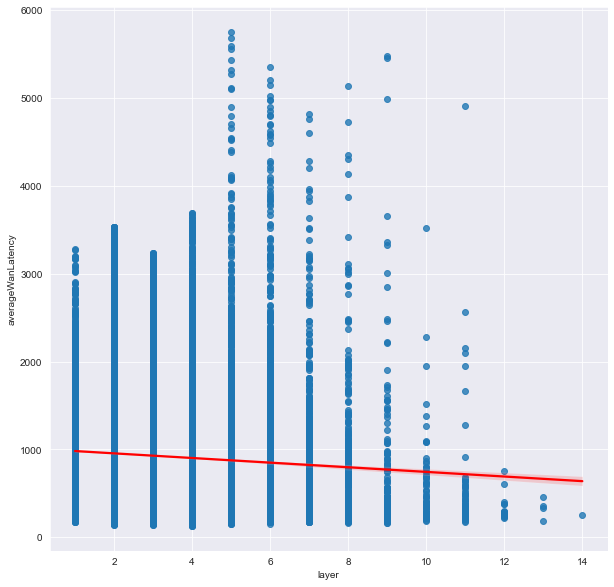

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.regplot(x='layer', y='averageWanLatency', data=analyticDF, line_kws={'color':'red'})

In [37]:
fig.savefig(save +'/avgWANbyLayerScatter.png')

In [38]:
df.averageWanLatency.describe(include='all').to_clipboard()

In [39]:
analyticDF.averageWanLatency.describe().to_clipboard()

In [40]:
analyticDF.loc[analyticDF.layer == 13]['averageWanLatency'].describe()

count      4.000000
mean     334.750000
std      112.342853
min      186.000000
25%      299.250000
50%      347.500000
75%      383.000000
max      458.000000
Name: averageWanLatency, dtype: float64

In [41]:
analyticDF.loc[analyticDF.layer == 1]['averageWanLatency'].describe()

count    3230.000000
mean     1022.153560
std       528.417247
min       174.000000
25%       618.250000
50%       938.500000
75%      1326.750000
max      3286.000000
Name: averageWanLatency, dtype: float64

In [42]:
a = analyticDF.loc[analyticDF.layer == 13]['averageWanLatency'].copy()
b = analyticDF.loc[analyticDF.layer == 1]['averageWanLatency'].copy()

pt.ttest(a, b, correction='auto')

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-12.073326,3.166638,two-sided,0.000939,"[-863.32, -511.49]",1.30145,7.255e+28,0.739096


In [43]:
# Average WAN Latency by Largest Hop Analysis

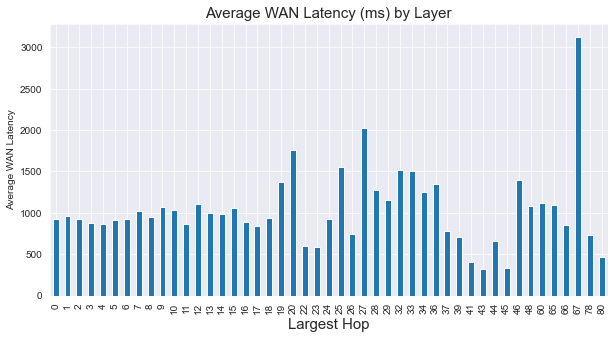

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = analyticDF.groupby('largestHop_int')['averageWanLatency'].mean().plot.bar()
ax.set_title('Average WAN Latency (ms) by Layer', fontsize=15)
ax.set_xlabel('Largest Hop', fontsize=15)
ax.set_ylabel('Average WAN Latency');

In [45]:
analyticDF.averageWanLatency.corr(analyticDF.largestHop)

0.0007833548388690128

In [46]:
analyticDF.largestHop.describe()

count    56672.000000
mean         3.837402
std          4.986934
min          0.003187
25%          0.950770
50%          2.581203
75%          4.446954
max         79.773283
Name: largestHop, dtype: float64

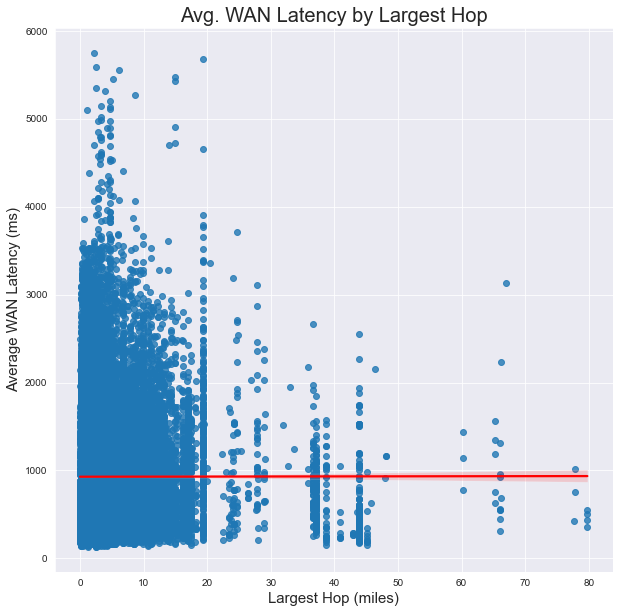

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.regplot(x='largestHop', y='averageWanLatency', data=analyticDF, line_kws={'color':'red'})
ax.set_xlabel('Largest Hop (miles)', fontsize=15)
ax.set_ylabel('Average WAN Latency (ms)', fontsize=15)
ax.set_title('Avg. WAN Latency by Largest Hop', fontsize=20);

In [48]:
pearsonr(analyticDF.averageWanLatency, analyticDF.largestHop)

(0.0007833548388690281, 0.8520680157023905)

In [49]:
fig.savefig(save+'/avgWANbyLargestHop.png')

# Total Geographic Distance to the Collector

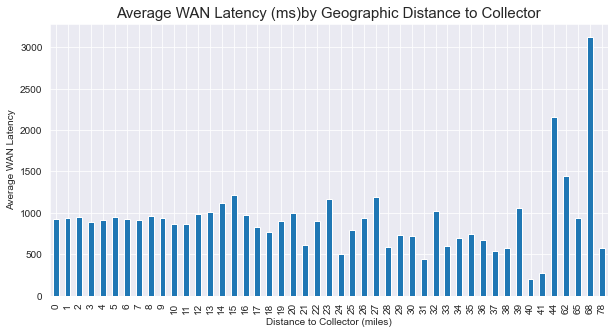

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = analyticDF.groupby('distanceToCollector_int')['averageWanLatency'].mean().plot.bar();
ax.set_title('Average WAN Latency (ms)by Geographic Distance to Collector', fontsize=15)
ax.set_xlabel('Distance to Collector (miles)', fontsize=10)
ax.set_ylabel('Average WAN Latency', fontsize=10);

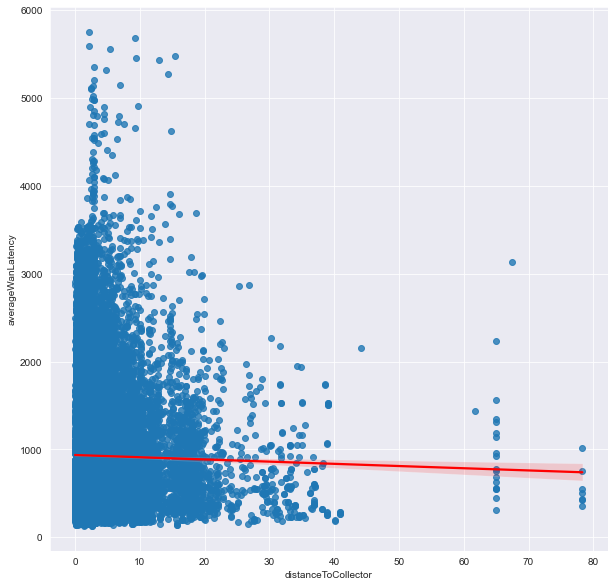

In [51]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.regplot(x='distanceToCollector', y='averageWanLatency', data=analyticDF, line_kws={'color':'red'})

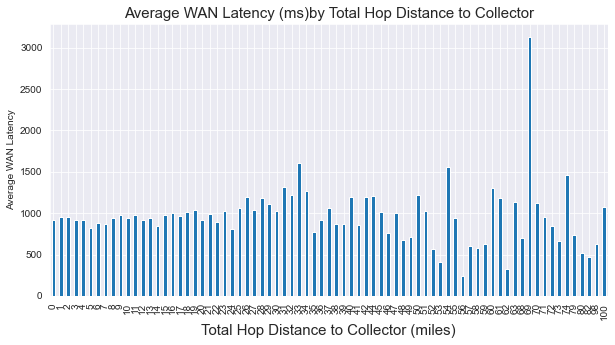

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = analyticDF.groupby('totalHopDistance_int')['averageWanLatency'].mean().plot.bar();
ax.set_title('Average WAN Latency (ms)by Total Hop Distance to Collector', fontsize=15)
ax.set_xlabel('Total Hop Distance to Collector (miles)', fontsize=15)
ax.set_ylabel('Average WAN Latency');

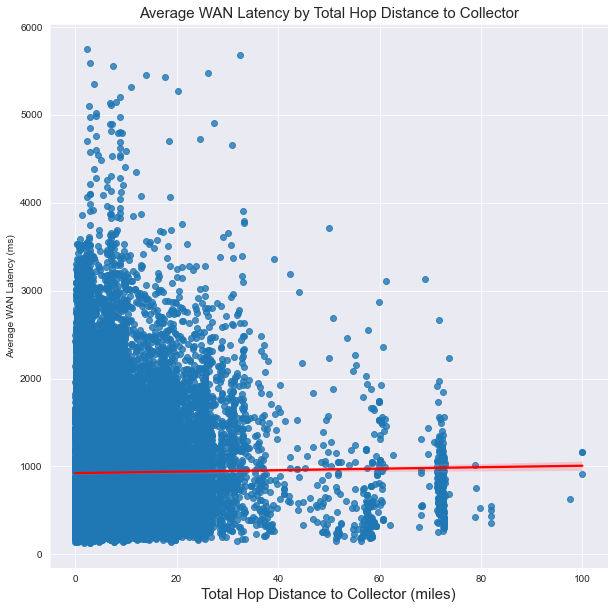

In [53]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.regplot(x='totalHopDistance', y='averageWanLatency', data=analyticDF, line_kws={'color':'red'})
ax.set_title('Average WAN Latency by Total Hop Distance to Collector', fontsize=15)
ax.set_xlabel('Total Hop Distance to Collector (miles)', fontsize=15)
ax.set_ylabel('Average WAN Latency (ms)');

In [54]:
pearsonr(analyticDF.totalHopDistance, analyticDF.averageWanLatency)

(0.012277985909634047, 0.003467561504596791)

In [55]:
fig.savefig(save+'/avgWANbyTotalHopDistance.png')

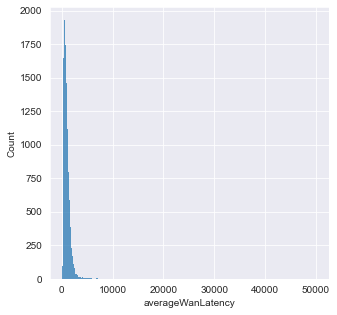

In [56]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.histplot(data=df, x='averageWanLatency')

In [57]:
df.averageWanLatency.quantile([0,.25,.5,.75,1])

0.00      128.0
0.25      514.0
0.50      811.0
0.75     1222.0
1.00    50001.0
Name: averageWanLatency, dtype: float64

### Average WAN Latency Data Frame 

#### Number of removed meters due to extreme outliers

In [58]:
analyticDF.largestHop.describe()

count    56672.000000
mean         3.837402
std          4.986934
min          0.003187
25%          0.950770
50%          2.581203
75%          4.446954
max         79.773283
Name: largestHop, dtype: float64

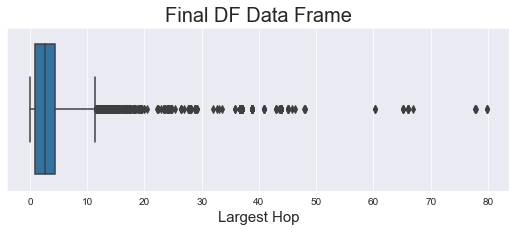

In [59]:
size = 'Final DF'
title = f'{size} Data Frame'
fig, ax = plt.subplots(figsize=(9, 3))
ax = sns.boxplot(data=analyticDF, x='largestHop', whis=2)
ax.set_title(title, fontsize=20)
ax.set_xlabel('Largest Hop', fontsize=15);

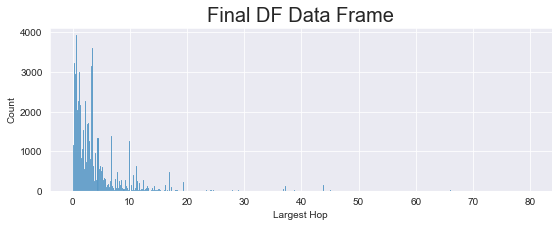

In [60]:
fig, ax = plt.subplots(figsize=(9, 3))
ax = sns.histplot(data=analyticDF, x='largestHop')
ax.set_title(title, fontsize=20)
ax.set_xlabel('Largest Hop');

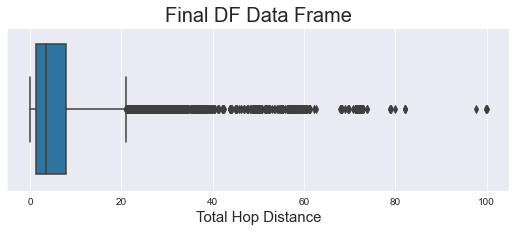

In [61]:
size = 'Final DF'
title = f'{size} Data Frame'
fig, ax = plt.subplots(figsize=(9, 3))
ax = sns.boxplot(data=analyticDF, x='totalHopDistance', whis=2)
ax.set_title(title, fontsize=20)
ax.set_xlabel('Total Hop Distance', fontsize=15);

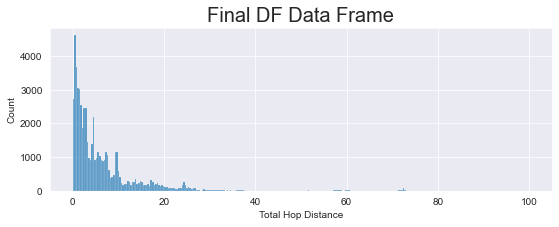

In [62]:
fig, ax = plt.subplots(figsize=(9, 3))
ax = sns.histplot(data=analyticDF, x='totalHopDistance')
ax.set_title(title, fontsize=20)
ax.set_xlabel('Total Hop Distance');

In [63]:
cor = analyticDF[cols].corr()

In [64]:
cols = ['lagTimeSeconds',
        'layer',
        'latestTickleSuccess',
        'numberOfNeighbors',
        'responseTimeToLive',
        'collectorDelay',
        'wanDataSuccess',
        'wanPacketsReceived',
        'wanPacketsTransmitted',
        'tickleSuccess',
        'transparentPacketsReceived',
        'transparentPacketsTransmitted',
        'largestHop',
        'distanceToCollector',
        'totalHopDistance',
        'rssi_dBm',
        'rfPower_dBm',
        'daysFromLastReboot',
        'averageWanLatency']

# REDO THE ANALYSIS WITH THE NEW ANALYTICDF

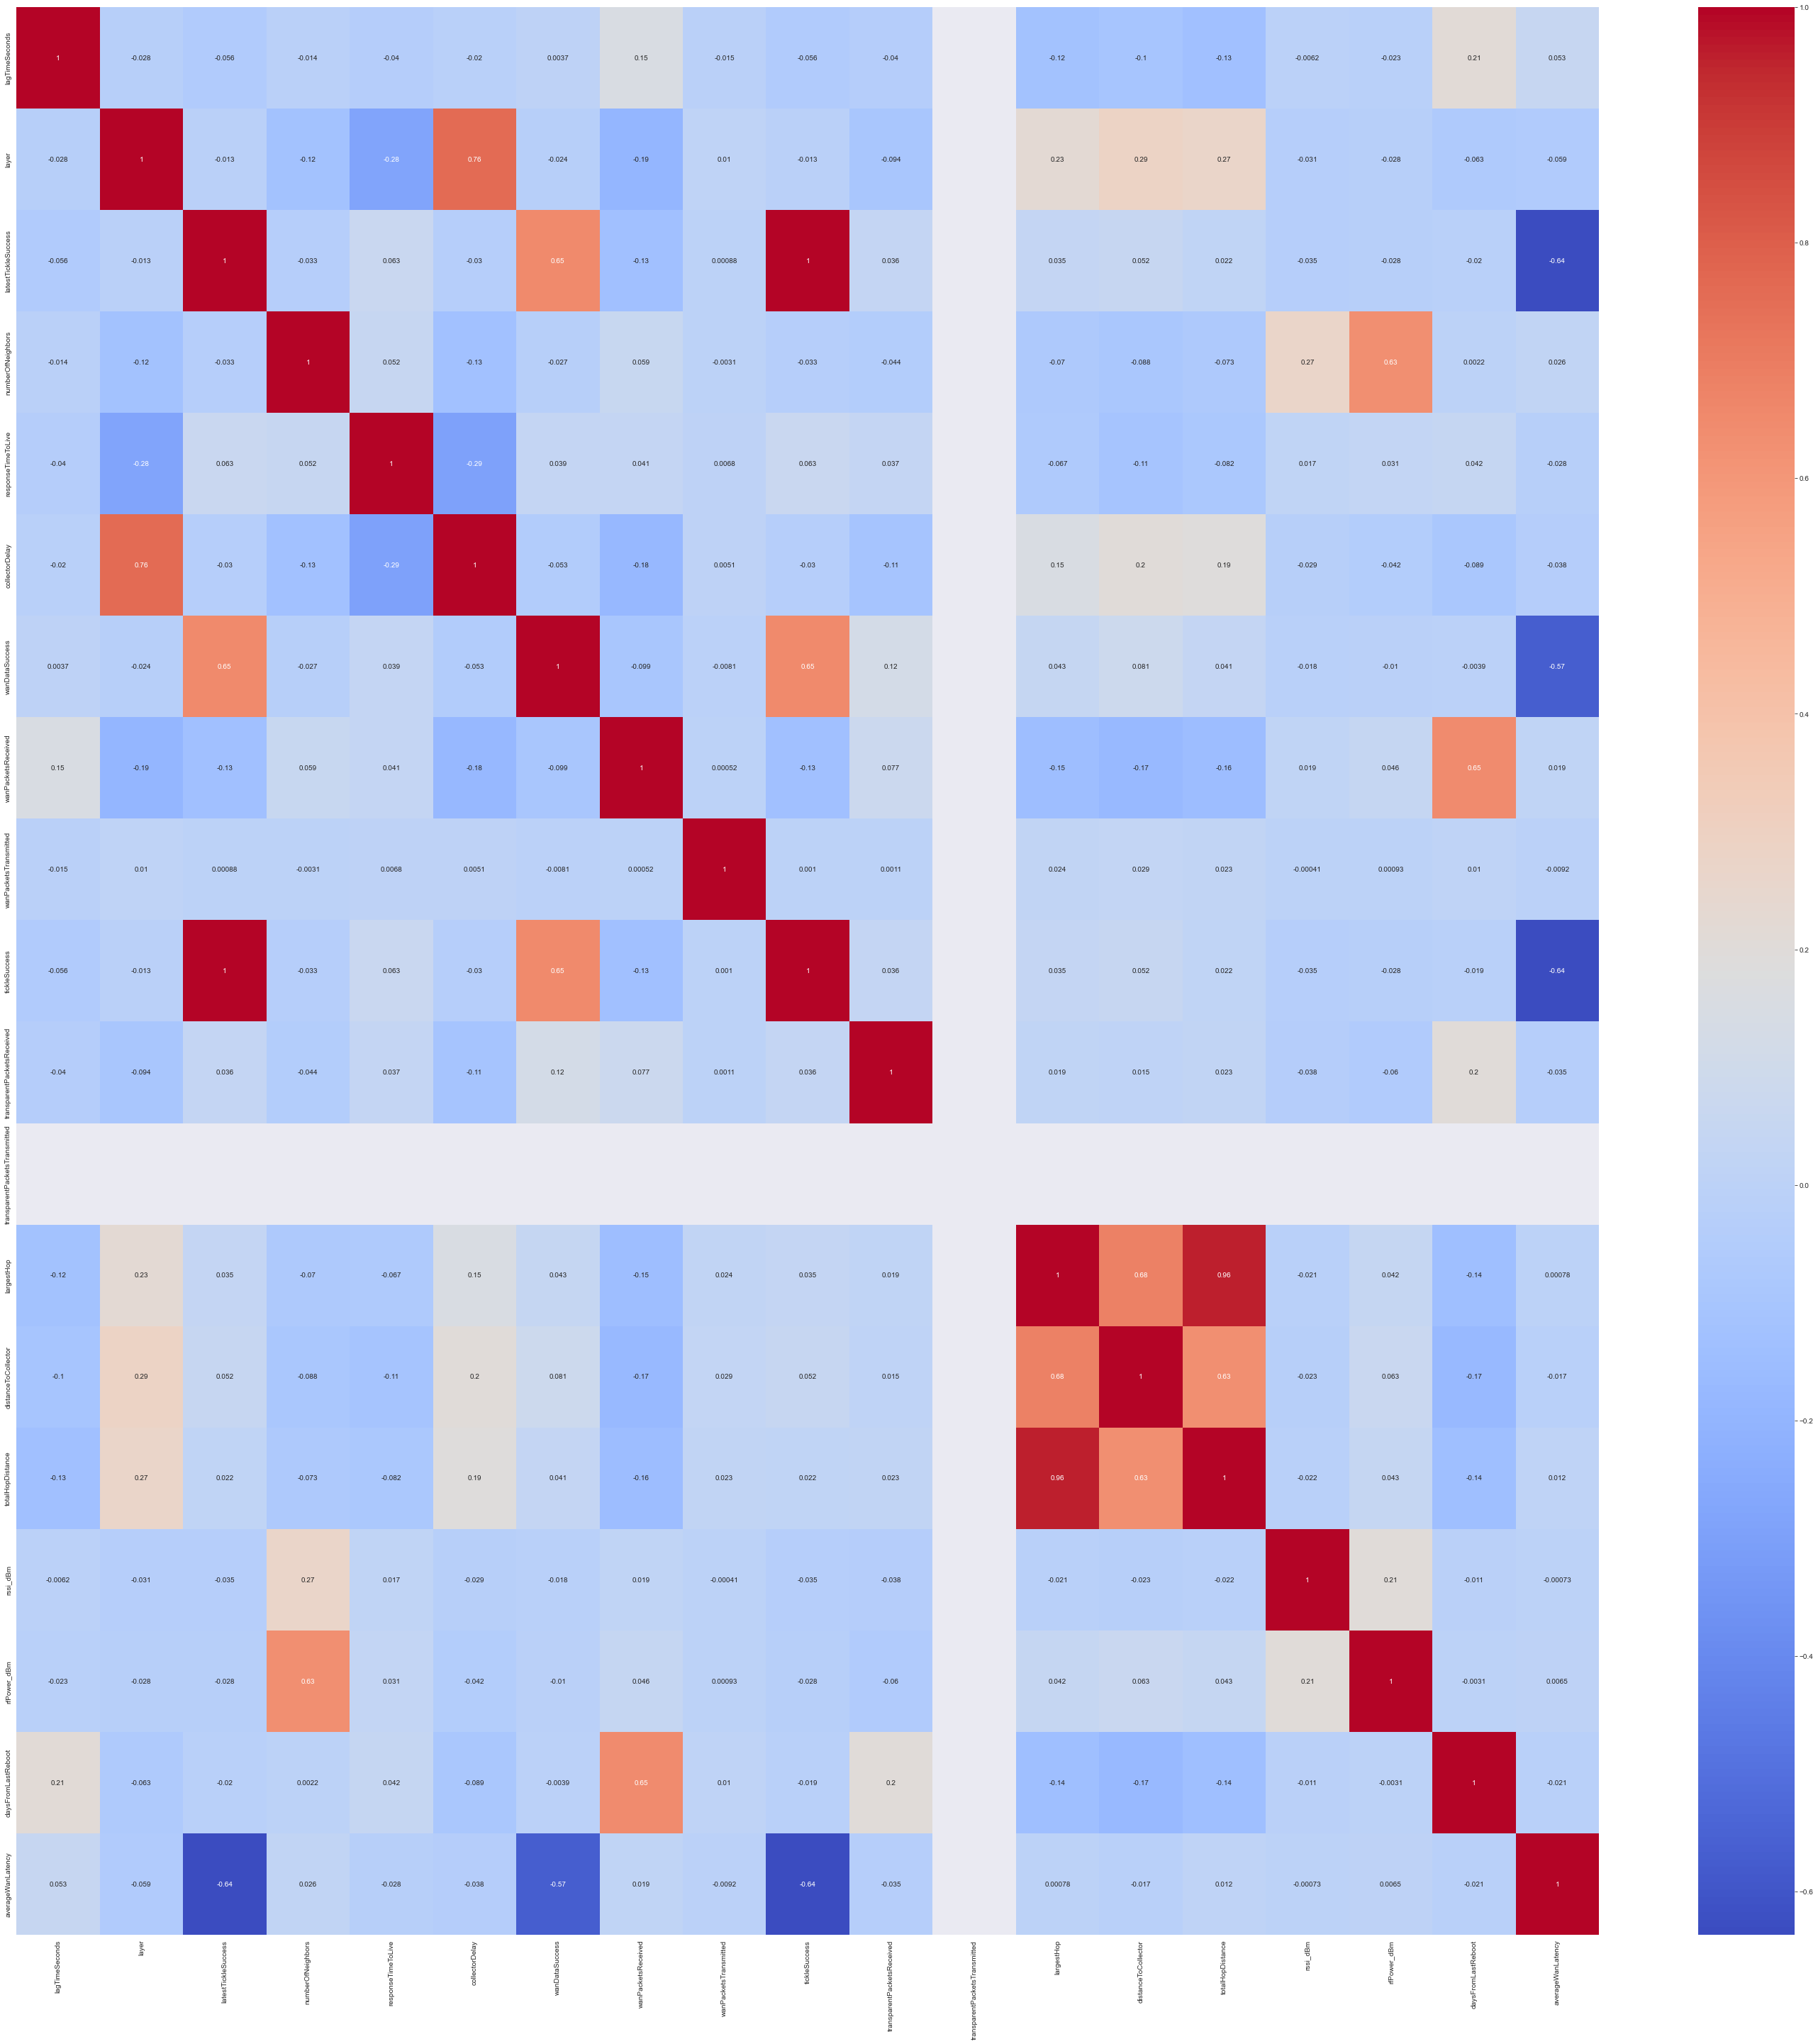

In [65]:
cor = analyticDF[cols].corr()
fig, ax = plt.subplots(figsize=(50,50))
ax = sns.heatmap(cor, cmap='coolwarm', annot=True);

# Stepwise Model

* <u>pathCount</u> removed because it is nearly identical to layer
* <u>meterStackCount</u> removed because it does not measure up to what CC says
* <u>activeWanNeighbors</u> removed because it is a duplicate of numberOfNeighbors

In [66]:
cols = ['lagTimeSeconds',
        'layer',
        'latestTickleSuccess',
        'numberOfNeighbors',
        'responseTimeToLive',
        'collectorDelay',
        'wanDataSuccess',
        'wanPacketsTransmitted',
        'wanPacketsReceived',
        'tickleSuccess',
        'transparentPacketsReceived',
        'transparentPacketsTransmitted',
        'largestHop',
        'distanceToCollector',
        'totalHopDistance',
        'rssi_dBm',
        'daysFromLastReboot',
        'averageWanLatency']

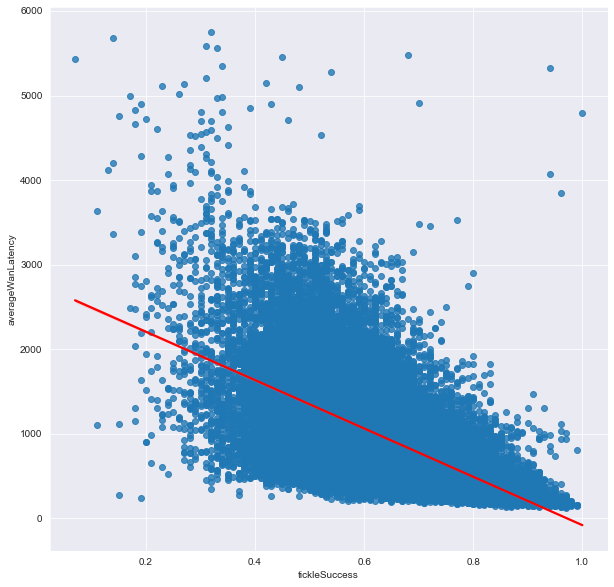

In [67]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.regplot(x='tickleSuccess', y='averageWanLatency', data=analyticDF, line_kws={'color':'red'})

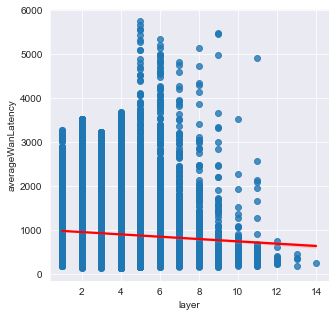

In [68]:
fig, ax = plt.subplots(figsize=(5,5))
ax = sns.regplot(x='layer', y='averageWanLatency', data=analyticDF, line_kws={'color':'red'})

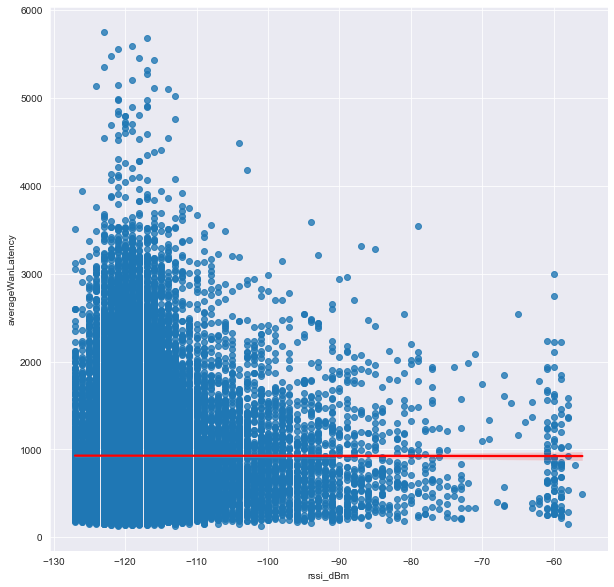

In [69]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.regplot(x='rssi_dBm', y='averageWanLatency', data=analyticDF, line_kws={'color':'red'})

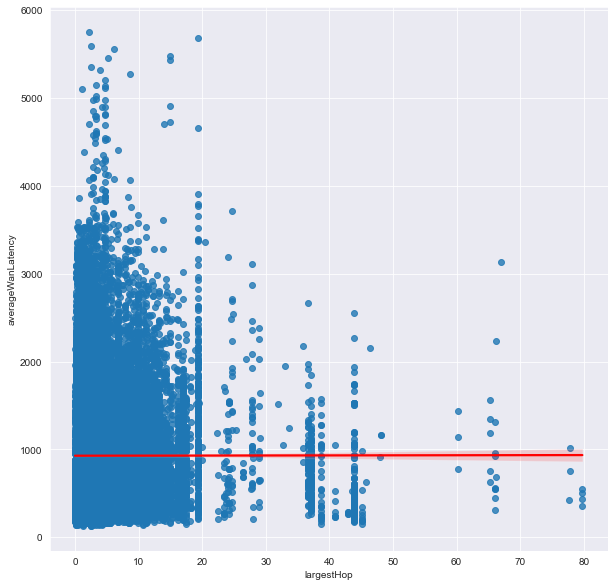

In [70]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.regplot(x='largestHop', y='averageWanLatency', data=analyticDF, line_kws={'color':'red'})

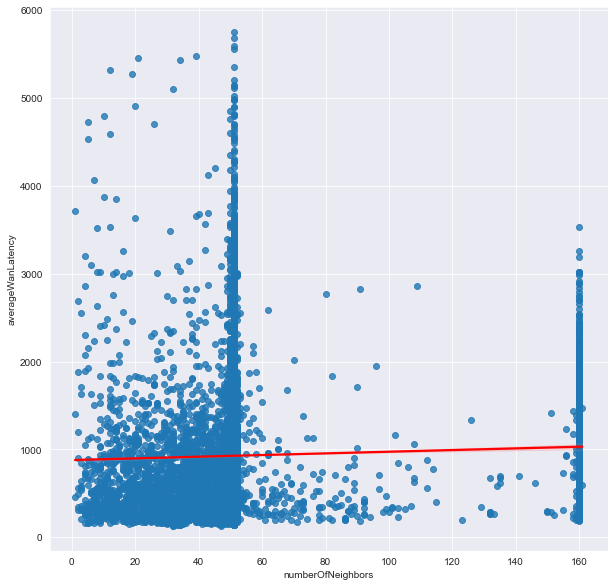

In [71]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.regplot(x='numberOfNeighbors', y='averageWanLatency', data=analyticDF, line_kws={'color':'red'})
ax;

In [72]:
fig.savefig(save+'/NumberOfNeig.png')

In [73]:
# Columns rremove
cols.remove('averageWanLatency') # this is the dependent variable
cols.remove('latestTickleSuccess') # p>|t| = 0.141
cols.remove('wanPacketsTransmitted') # p>|t| = 0.247
cols.remove('transparentPacketsReceived') # No values
cols.remove('daysFromLastReboot')
cols.remove('responseTimeToLive')
cols.remove('wanPacketsReceived') # No values
cols.remove('transparentPacketsTransmitted') # No values
cols.remove('lagTimeSeconds')
cols.remove('distanceToCollector')
cols.remove('totalHopDistance')
cols.remove('collectorDelay')
cols.remove('wanDataSuccess')

In [74]:
results = get_stats(analyticDF, cols)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      averageWanLatency   R-squared (uncentered):                   0.827
Model:                            OLS   Adj. R-squared (uncentered):              0.827
Method:                 Least Squares   F-statistic:                          5.420e+04
Date:                Mon, 04 Oct 2021   Prob (F-statistic):                        0.00
Time:                        12:42:01   Log-Likelihood:                     -4.2707e+05
No. Observations:               56672   AIC:                                  8.541e+05
Df Residuals:                   56667   BIC:                                  8.542e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
layer               -21.7255      1.534    -14.166      0.000     -24.731     -18.720
numberOfNeighbors     3.5430      0.115     30.754      0.000       3.317       3.769
tickleSuccess     -2667.9566     14.663   -181.953      0.000   -2696.696   -2639.217
largestHop            4.8071      0.393     12.240      0.000       4.037       5.577
rssi_dBm            -21.2956      0.101   -209.945      0.000     -21.494     -21.097
==============================================================================
Omnibus:                    16845.667   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            85169.510
Skew:                           1.353   Prob(JB):                         0.00
Kurtosis:                       8.362   Cond. No.                         995.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
params = results.params
params.sort_values().to_clipboard()

In [76]:
results.tvalues.sort_values()

rssi_dBm            -209.945379
tickleSuccess       -181.953065
layer                -14.165932
largestHop            12.239958
numberOfNeighbors     30.754122
dtype: float64

In [77]:
round(results.fvalue, 2)

54198.49

### Prepare for sklearn MLR Model
#### Seperate dependedn and independent variables

In [78]:
X = analyticDF[cols] # independent variables
y = analyticDF['averageWanLatency'] # dependent variable

#### Dummy Layer column

In [79]:
layers = pd.get_dummies(X['layer'], drop_first=True)
X.drop('layer', axis=1, inplace=True)
X = pd.concat([X, layers], axis=1)

#### Split dataset into train/test
* Training set = 80%
* Test set = 20% 

In [80]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Fit MLR to training set

In [81]:
regressor = LinearRegression()
regressor.fit(X_train,y_train)

LinearRegression()

In [82]:
y_pred = regressor.predict(X_test)

In [83]:
score = r2_score(y_test,y_pred)

In [84]:
score

0.4215213089042028

# Investigate High Latency
* A high latencey data frame includes all endpoints with a lagency that exceeds the upper quartile. This data frame will initially include all outliers.


In [ ]:
df.averageWanLatency.describe()

In [ ]:
highLatenceyDF = df.loc[df.averageWanLatency > 1222].copy()
highLatenceyDF.reset_index(inplace=True, drop=True)

In [ ]:
def map_devices(dfOrg, all = 'all'):
    '''
    Create router map
    '''
    
    df = dfOrg.copy()
    df.reset_index(inplace=True, drop=True)
    
    map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()],
                 zoom_start=9)
    
    
    FastMarkerCluster(data=list(zip(df['latitude'].values, df['longitude'].values))).add_to(map)
    # Change listing in the folium control
    #folium.LayerControl(lable='Marker Counts').add_to(map)
    
    for i in df.index:

        popup_text = f"High Latency Meter: {df.at[i, 'meterNo']}, \n RF Power: {df.at[i, 'rfPower']} \n Average WAN Latency {df.at[i,'averageWanLatency']} \n Collector: {df.at[i, 'name']}"

        folium.CircleMarker(location=(df.at[i, 'latitude'],df.at[i, 'longitude']),
                                                 radius= 3,
                                                 popup=popup_text,
                                                 clustered_marker = True).add_to(map)
        
    
    #add_legend(map, all)

    return map

In [ ]:
highLatenceyDF['color'] = highLatenceyDF['name'].apply(set_value, args =(colorDict, ))

In [ ]:
map = map_devices(highLatenceyDF)
map = add_full_screen(map)
map

In [ ]:
latencyLabel = list(highLatenceyDF.groupby('layer').averageWanLatency.mean())
x = np.arange(len(latencyLabel))
width = 0.35

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
rects = ax.bar(x - width/2, latencyLabel, width)
ax = highLatenceyDF.groupby('layer')['averageWanLatency'].mean().plot.bar();
ax.set_title('Average WAN Latency (ms) by Layer', fontsize=15)
ax.set_xlabel('Layer', fontsize=15)
ax.set_ylabel('Average WAN Latency')

ax.bar_label(rects, padding=3);